In [401]:
import scipy.version as version
import numpy as np
import scipy.integrate as nint
import scipy.interpolate as interp
import scipy.stats as stats
import scipy.optimize as opt
import scipy.misc as mis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import math

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
plt.style.use("seaborn-bright")
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10
plt.rc('text', usetex=True)

deg_k_smooth_spl = 5
extra_spl = 0 # 0 extrapolation , 1 zero; 2 error; 3 boundary values
def interp_spl(space, funct, der):
    tck = interp.splrep(space, funct, k=deg_k_smooth_spl, s=1)#, ext=extra_spl)
    return interp.splev(space, tck, der=der, ext=0)

interp_funct = lambda space, funct : interp.interp1d(space, funct, kind='cubic', fill_value='extrapolate')

The flat metric in spherical coordinates is

$\mathrm{d}s^2 = -\mathrm{d}t^2 + \mathrm{d}r^2 + r^2\mathrm{d}\theta^2 + r^2\sin^2\theta\,\mathrm{d}\phi^2$,

and the matter Lagrangian is a free scalar field,

$\mathcal{L}_{\text{matter}} = -(\partial_\mu \Phi + ie A_\mu\Phi)(\partial^\mu \Phi^* - ie A^\mu\Phi^*)-\lambda (|\Phi|^2-v^2)^2-\frac{1}{4}|F_{\mu\nu}|^2$. We also decompose the complex scalar $\Phi$ to two real scalars $\Phi = \frac{1}{\sqrt{2}}(\phi_1 + i\phi_2)$ when simulation is needed.

We use the radiation gauge $\mathbf{k}\cdot\mathbf{A}=0$ and spherical symmetry to set $A_\mu = (a,0,0,0)$, where the only non-vanishing component is $A_t=a$.

1. $\dot{\Phi} = {\psi^6}p - iqa\Phi$,

2. $a' = g$

3. $\dot{p} = \frac{1}{r^2}\partial_r(r^2\Phi')-2\lambda \Phi^*(|\Phi|^2-v^2) -iqap$,

4. $\dot{g} = iq(\Phi\Phi^*\,\!' - \Phi^* \Phi') = q(\phi_1 \phi_2' - \phi_1'\phi_2) $

In [195]:
kap = 1.0
vev = 0.0
q = 1.0
At = 5.0
#m2chi = 1.
epsilon_phi = 1e-2

kapsq = kap**2
vevsq=vev**2

m_schwarz = 1.0
q_schwarz = 0.5
r_min = 0.44
r_max = 100.
r_div = int(1e2)


print('The horizon is at r = ' + str(np.sqrt(m_schwarz**2-q_schwarz**2)/2.))

print("spatial step size = ", str((r_max-r_min)/r_div))

rr = np.linspace(r_min, r_max, r_div)
logit = lambda x: np.log(np.abs(x))

The horizon is at r = 0.4330127018922193
('spatial step size = ', '0.9956')


In [408]:
metric_use = "NR"

N_s = lambda r: 1.*np.ones_like(rr)
N_r_s = lambda r: 0.*np.ones_like(rr)
psi_s = lambda r: 1.*np.ones_like(rr)
psi_r_s = lambda r: 0.*np.ones_like(rr)
C_s = lambda r: 0.*np.ones_like(rr)
a_r_s = lambda r: 0.*np.ones_like(rr)
a_s = lambda r: 0.*np.ones_like(rr)

if metric_use == "NR":
    N_s = lambda r: (1.-(m_schwarz**2 - q_schwarz**2)/(4.*r**2))/(1.+m_schwarz/r+(m_schwarz**2 - q_schwarz**2)/(4.*r**2) )
    N_r_s = lambda r: (m_schwarz/r**2 + (m_schwarz**2 - q_schwarz**2)/r**3 + (m_schwarz/r**2)*(m_schwarz**2 - q_schwarz**2)/(4.*r**2) )/(1.+m_schwarz/r+(m_schwarz**2 - q_schwarz**2)/(4.*r**2))**2
    psi_s = lambda r: np.sqrt(1+m_schwarz/r+(m_schwarz**2 - q_schwarz**2)/(4.*r**2))
    psi_r_s = lambda r: -((m_schwarz**2 - q_schwarz**2)/(4.*r**2) + (m_schwarz/(2.*r)))/(r*psi_s(r))
    C_s = lambda r: np.sqrt(2.)*q_schwarz*np.ones_like(r)/kap
    a_r_s = lambda r: C_s(r)*(1. - (m_schwarz**2 - q_schwarz**2)/(4*r**2))/(r*(1 + m_schwarz/r + (m_schwarz**2-q_schwarz**2)/(4*r**2)))**2 
    a_s = lambda r: -C_s(r)/(r*(1 + m_schwarz/r + (m_schwarz**2-q_schwarz**2)/(4*r**2)))
elif metric_use == "Min":
    N_s = lambda r: 1.*np.ones_like(rr)
    N_r_s = lambda r: 0.*np.ones_like(rr)
    psi_s = lambda r: 1.*np.ones_like(rr)
    psi_r_s = lambda r: 0.*np.ones_like(rr)
    C_s = lambda r: 0.*np.ones_like(rr)
    a_r_s = lambda r: 0.*np.ones_like(rr)
    a_s = lambda r: 0.*np.ones_like(rr)

In [197]:
def df_dx(x, f, n_bnd=None):
    delta_x = x[1]-x[0]
    #x_plus = x+delta_x; x_minus = x-delta_x
    x_plus = x+delta_x
    if n_bnd is None:
        f_dx = (f(x_plus) - f(x))/delta_x
    else:
        f_dx = (f(x_plus[:-1]) - f(x[:-1]))/delta_x
        f_bnd = f_dx[-1]*(x_plus[-1]/x[-1])**(n_bnd-1)
        f_dx = np.hstack((f_dx, f_bnd))
    return f_dx

def ddf_dxdx(x, f, n_bnd=None):
    delta_x = x[1]-x[0]
    #x_plus = x+delta_x; x_minus = x-delta_x
    x_plus = x+delta_x; x_plus_2 = x + 2*delta_x; x_plus_3 = x + 3*delta_x
    if n_bnd is None:
        f_dxdx = (2.*f(x) -5.*f(x_plus) + 4.*f(x_plus_2) - f(x_plus_3))/(delta_x**2)    
    else:   
        f_dxdx = ( 2*f(x[:-3]) - 5.*f(x_plus[:-3]) + 4.*f(x_plus_2[:-3]) - f(x_plus_3[:-3]) )/(delta_x**2)
        f_bnd_1 = (f_dxdx[-1])*(x_plus[-1]/x[-1])**(n_bnd-2)
        f_bnd_2 = (f_dxdx[-1])*(x_plus_2[-1]/x[-1])**(n_bnd-2)
        f_bnd_3 = (f_dxdx[-1])*(x_plus_3[-1]/x[-1])**(n_bnd-2)
        f_dxdx = np.hstack(( f_dxdx, f_bnd_1, f_bnd_2, f_bnd_3 ))
    return f_dxdx


# Scalar only equation in field polar coordinates


$\dot{\rho} = \frac{N}{\psi^6}k$,

$\dot{\alpha} = \frac{N}{\psi^6}\beta - qA_t$,

$\dot{k} = \frac{1}{r^2}\partial_r(r^2N\psi^2\rho') + \frac{N}{\psi^6}\rho\beta^2 - N\psi^2\rho\alpha^{\prime 2} - N\psi^6\frac{{\rm d}V(\rho)}{{\rm d}\,{\rho}}$,

$\dot{\beta} = -2\frac{N}{\psi^6}\beta\frac{k}{\rho} + 2N\psi^2\alpha'\frac{\rho'}{\rho}+\frac{1}{r^2}\partial_r(r^2N\psi^2\alpha')$.

In [198]:
m_X = -10.

def pot(t,rho):
    lamb = 0.1
    return np.zeros_like(rho)#m_X*rho + lamb*rho**3

def drho_dt(N, psi, k):
    return N*k/psi**6

def dC_dt(r, rho, alpha_dr):
    C_dt = q*N*(psi**2)*(rho**2)*alpha_dr
    return C_dt
    
def dalpha_dt(N, psi, beta):
    beta_dt = N*beta/psi**6 - q*At
    return beta_dt

def dk_dt(r, N, psi, beta, rho, N_dr, psi_dr, alpha_dr, rho_dr, rho_drdr, t):
    k_dt = 2.*N*(psi**2)*rho_dr/r + N_dr*(psi**2)*rho_dr + 2.*N*psi*psi_dr*rho_dr + N*(psi**2)*rho_drdr + \
                N*rho*beta**2/(psi**6) - N*(psi**2)*rho*alpha_dr**2 - N*(psi**6)*pot(t,rho)
    return k_dt

def dbeta_dt(r, N, psi, k, beta, rho, N_dr, psi_dr, alpha_dr, rho_dr, alpha_drdr, t):
    if (t == dt):# or (t == 2.*dt) or (t == 3.*dt):
        return 2.*np.ones_like(r)*m_X*beta
    beta_dt = -2.*N*beta*k/(rho*psi**6) + 2.*N*(psi**2)*alpha_dr*rho_dr/rho + 2.*N*(psi**2)*alpha_dr/r + \
                N*(psi**2)*alpha_drdr + N_dr*(psi**2)*alpha_dr + 2.*psi_dr*N*psi*alpha_dr
    return beta_dt

In [373]:
def fun_t(r, y, dt, t, verbose=False):
    
    rho_in = y[0]; alpha_in = y[1];  k_in = y[2]; beta_in = y[3];

    rho_dr_in = df_dx(r, rho_in)
    alpha_dr_in = df_dx(r, alpha_in)

    rho_drdr_in = ddf_dxdx(r, rho_in)    
    alpha_drdr_in = ddf_dxdx(r, alpha_in)
    
    rho_grid_in = rho_in(r)
    alpha_grid_in = alpha_in(r)
    k_grid_in = k_in(r)
    beta_grid_in = beta_in(r)

    N_grid = N_s(r)
    psi_grid = psi_s(r)
    N_dr_grid = N_r_s(r)
    psi_dr_grid = psi_r_s(r)
    
    
    
    rho_grid_mp = rho_grid_in + 0.5*dt*drho_dt(N_grid, psi_grid, k_grid_in)
    alpha_grid_mp = alpha_grid_in + 0.5*dt*dalpha_dt(N_grid, psi_grid, beta_grid_in)
    k_grid_mp = k_grid_in + 0.5*dt*dk_dt(r, N_grid, psi_grid, beta_grid_in, rho_grid_in, N_dr_grid, psi_dr_grid, \
                                      alpha_dr_in, rho_dr_in, rho_drdr_in, t)
    beta_grid_mp = beta_grid_in + 0.5*dt*dbeta_dt(r, N_grid, psi_grid, k_grid_in, beta_grid_in, rho_grid_in, \
                                               N_dr_grid, psi_dr_grid, alpha_dr_in, rho_dr_in, alpha_drdr_in, t)
    
    rho_mp = interp_funct(r, rho_grid_mp)
    alpha_mp = interp_funct(r, alpha_grid_mp)
    
    rho_dr_mp = df_dx(r, rho_mp)
    alpha_dr_mp = df_dx(r, alpha_mp)

    rho_drdr_mp = ddf_dxdx(r, rho_mp)    
    alpha_drdr_mp = ddf_dxdx(r, alpha_mp)
    
    rho_grid_out = rho_grid_in + dt*drho_dt(N_grid, psi_grid, k_grid_mp)
    alpha_grid_out = alpha_grid_in + dt*dalpha_dt(N_grid, psi_grid, beta_grid_mp)
    k_grid_out = k_grid_in + dt*dk_dt(r, N_grid, psi_grid, beta_grid_mp, rho_grid_mp, N_dr_grid, psi_dr_grid, \
                                      alpha_dr_mp, rho_dr_mp, rho_drdr_mp, t)
    beta_grid_out = beta_grid_in + dt*dbeta_dt(r, N_grid, psi_grid, k_grid_mp, beta_grid_mp, rho_grid_mp, \
                                               N_dr_grid, psi_dr_grid, alpha_dr_mp, rho_dr_mp, alpha_drdr_mp, t)
    

    #print dbeta_dt(r, N_grid, psi_grid, k_grid_in, beta_grid_in, rho_grid_in, N_dr_grid, psi_dr_grid, alpha_dr_in, rho_dr_in, alpha_drdr_in, t)
    
    rho_out = interp_funct(r, rho_grid_out)
    alpha_out = interp_funct(r, alpha_grid_out)
    k_out = interp_funct(r, k_grid_out)
    beta_out = interp_funct(r, beta_grid_out)

    fun_r_solve = lambda r, y: fun_r(r, metric_input, aux_input)
     
    return [rho_out, alpha_out, k_out, beta_out]

In [374]:
rho_init = interp_funct(rr, np.cos(rr)*np.ones_like(rr)/rr)
alpha_init = interp_funct(rr, 0.*np.zeros_like(rr))
k_init = interp_funct(rr, 1e-1*np.ones_like(rr))
#beta_init = interp_funct(rr, -1e-1*np.ones_like(rr))
beta_init = interp_funct(rr, np.zeros_like(rr))

t_end =1000
dt = 0.01

t_range = range(0,t_end)

vec_t = [rho_init, alpha_init, k_init, beta_init]
t_all = np.array(vec_t)
t_size = np.array([0.])
t_now = t_size[-1]

for t_step in tqdm(range(0,t_end)):
    t_now = t_size[-1]+dt
    vec_t = fun_t(rr, vec_t, dt, t_now)
    t_all = np.vstack((t_all, vec_t))
    t_size = np.hstack((t_size, t_now))

 42%|████▏     | 424/1000 [00:01<00:01, 368.12it/s]/Users/john/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in divide
/Users/john/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in divide
100%|██████████| 1000/1000 [00:02<00:00, 358.96it/s]


399


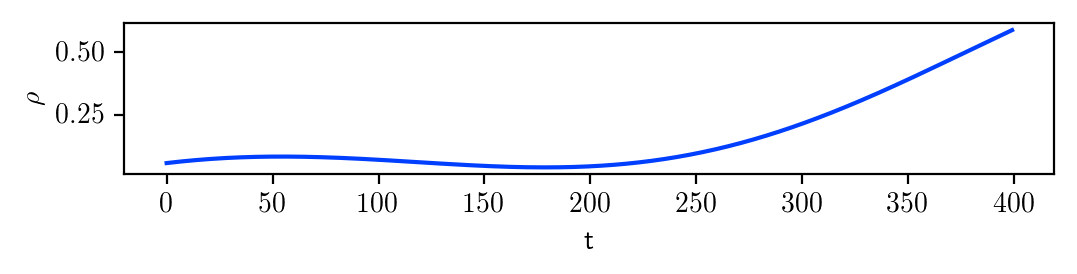

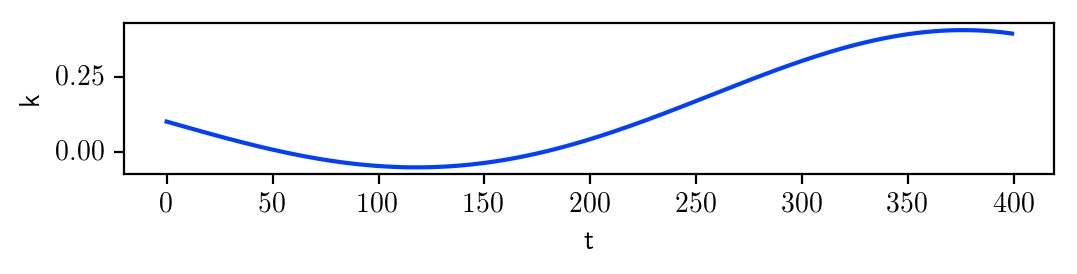

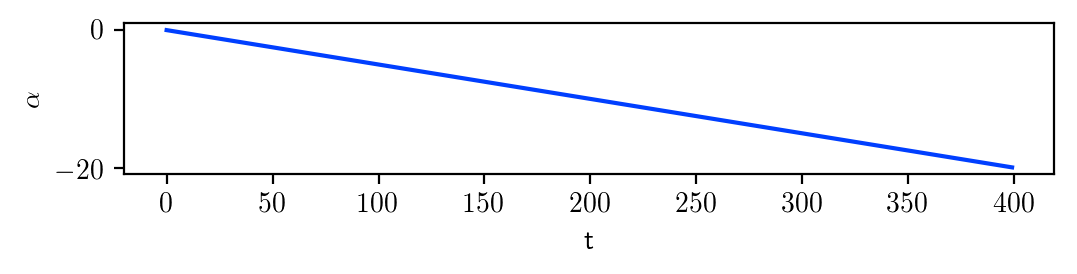

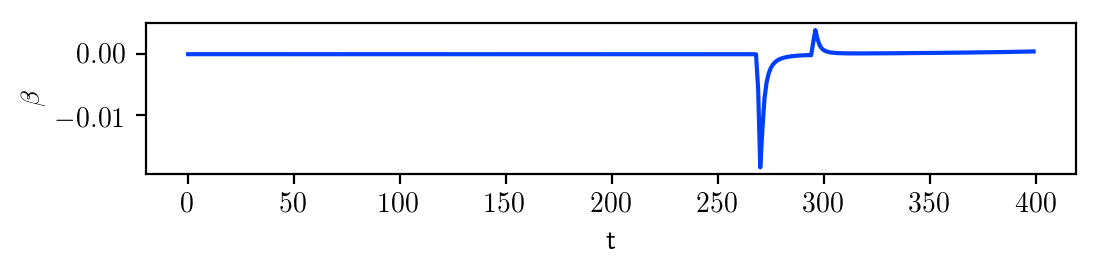

In [376]:
r_min_plot = r_min
r_max_plot = r_max

plot_t_range = range(0,400)#t_end)

result = np.array(t_all)

rho_result = result[:, 0];
alpha_result = result[:,1];
k_result = result[:,2];
beta_result = result[:,3]; 

rho_vec = np.array([])
k_vec = np.array([])
alpha_vec = np.array([])
beta_vec = np.array([])

r_to_plot = 5
print plot_t_range[-1]

for t_i in plot_t_range:
    rho_vec = np.append(rho_vec, rho_result[t_i](r_to_plot))
    k_vec = np.append(k_vec, k_result[t_i](r_to_plot))
    alpha_vec = np.append(alpha_vec, alpha_result[t_i](r_to_plot))
    beta_vec = np.append(beta_vec, beta_result[t_i](r_to_plot))


plt.figure(figsize=(6,1))
plt.plot(plot_t_range, rho_vec);
plt.ylabel("$\\rho$");plt.xlabel("t")
plt.show()
plt.figure(figsize=(6,1))
plt.plot(plot_t_range, k_vec);
plt.ylabel("k");plt.xlabel("t")
plt.show()
plt.figure(figsize=(6,1))
plt.plot(plot_t_range, alpha_vec);
plt.ylabel("$\\alpha$");plt.xlabel("t")
#plt.yscale("symlog")
plt.show()
plt.figure(figsize=(6,1))
plt.plot(plot_t_range, beta_vec);
plt.ylabel("$\\beta$");plt.xlabel("t")
#plt.yscale("symlog")
plt.show()

#time_range = range(10,1000,100)

#print("length of time steps: ", len(t_all))
#plot_t_slice_fields(t_all, time_range, rr_plot, log=False)

In [202]:
plot_alpha = 0.7

def plot_t_slice_fields(t_all, t_slices, r, log=False):
    result = np.array(t_all)[t_slices]
    rho_result = result[:,0]; alpha_result = result[:,1]; k_result = result[:,2]; beta_result = result[:,3]; 
    grey_scale_color = np.linspace(0.0, 0.8, len(t_slices))

    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,5))
    plt.subplots_adjust(wspace = 0.2, hspace=0.5)
    for row in ax:
        for col in row:
           col.set_xlabel('$r$')
           col.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    for i, t_slice in enumerate(t_slices):
        if log:
            ax[0,0].plot(r, logit(rho_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[0,0].plot(r, rho_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[0,0].set_ylabel('$\\rho$'); #ax[0,0].legend();
        
    for i, t_slice in enumerate(t_slices):
        if log:
            ax[1,1].plot(r, logit(k_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[1,1].plot(r, k_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[1,1].set_ylabel('$k$'); #ax[1,1].legend();

    for i, t_slice in enumerate(t_slices):
        if log:
            ax[1,0].plot(r, logit(alpha_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[1,0].plot(r, alpha_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[1,0].set_ylabel('$\\alpha$'); #ax[1,0].legend();
    
    for i, t_slice in enumerate(t_slices):
        if log:
            ax[2,0].plot(r, logit(beta_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[2,0].plot(r, beta_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[2,0].set_ylabel('$\\beta$'); #ax[0,0].legend();
    

    print("Matter field contents")
    plt.show()

('length of time steps: ', 1001)
Matter field contents


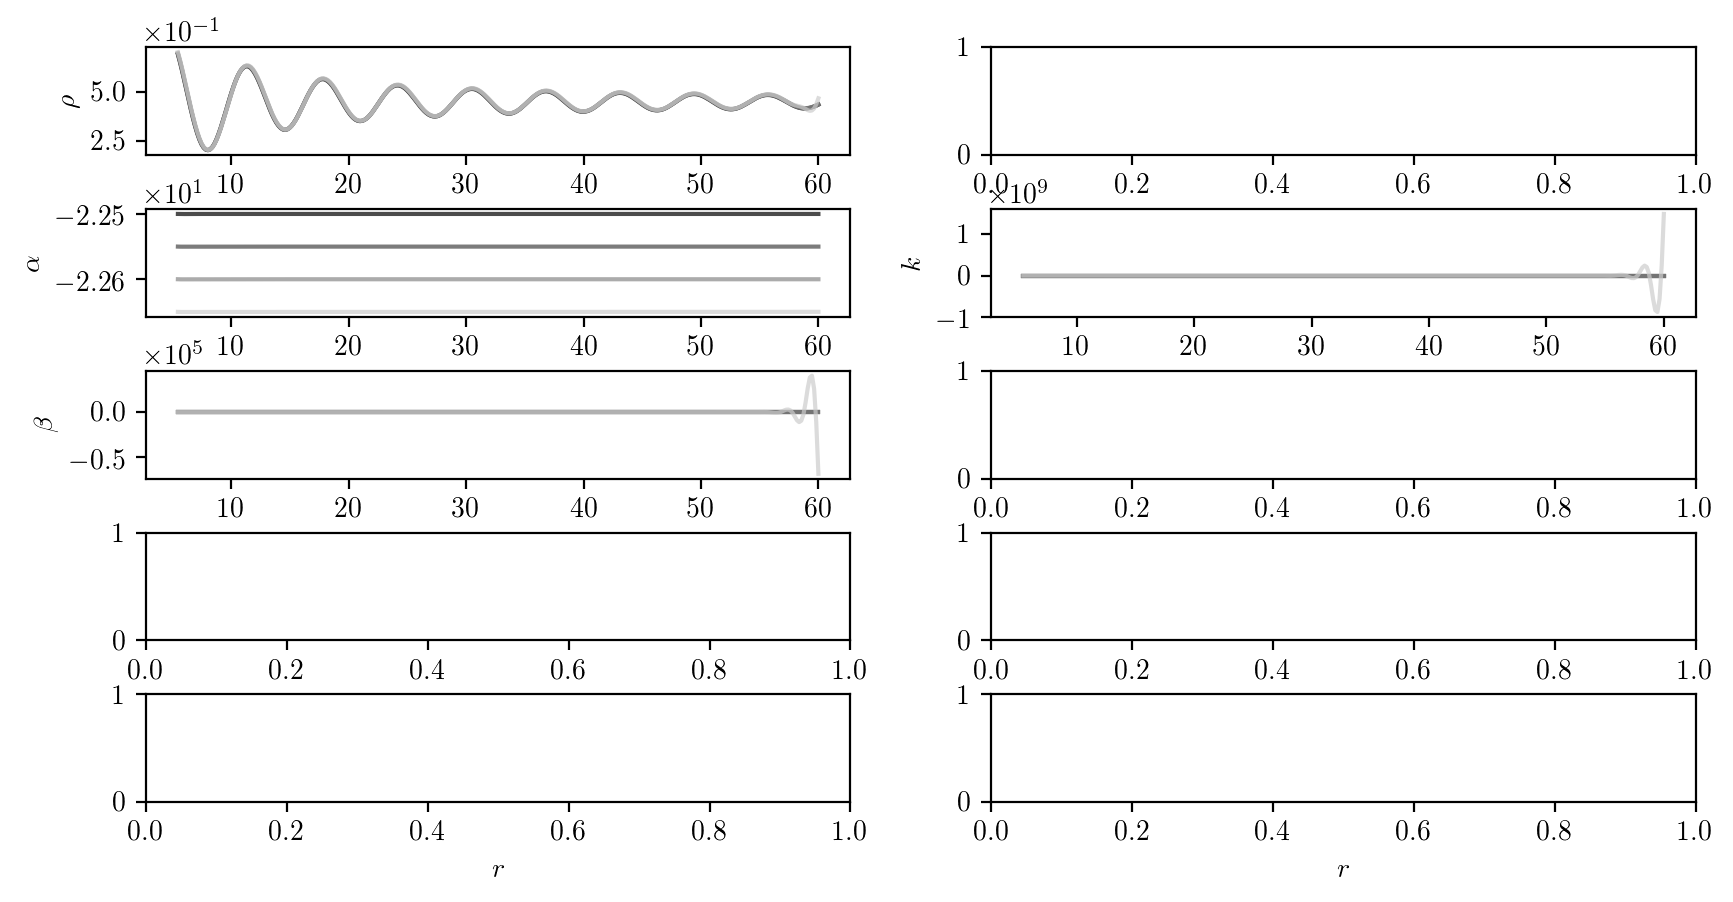

In [221]:
r_min_plot = r_min+5
r_max_plot = r_max-40

rr_plot = np.linspace(r_min_plot, r_max_plot, 300)
time_range = range(450,454,1)
result = t_all

print("length of time steps: ", len(t_all))
plot_t_slice_fields(result, time_range, rr_plot, log=False)

# Real-imaginary decomposition

In [409]:
def dX_1_dt(N, psi, X_2, a, p_1):
    X_1_t = N*p_1/(psi**6) + q*a*X_2
    return X_1_t

def dX_2_dt(N, psi, X_1, a, p_2):
    X_2_t = N*p_2/(psi**6) - q*a*X_1
    return X_2_t

def dp_1_dt(r, N, psi, X_1, X_2, a, p_2, N_dr, psi_dr, X_1_r, X_1_rr):
    p_1_t = 2.*N*(psi**2)*X_1_r/r + (psi**2)*N_dr*X_1_r + 2.*N*psi*psi_dr*X_1_r + N*(psi**2)*X_1_rr\
        - (psi**6)*N*X_1*(X_1**2+X_2**2-2.*m_X) + q*a*p_2
    return p_1_t

def dp_2_dt(r, N, psi, X_1, X_2, a, p_1, N_dr, psi_dr, X_2_r, X_2_rr):
    p_2_t = 2.*N*(psi**2)*X_2_r/r + (psi**2)*N_dr*X_2_r + 2.*N*psi*psi_dr*X_2_r + N*(psi**2)*X_2_rr\
        + (psi**6)*N*X_2*(X_1**2+X_2**2-2.*m_X) - q*a*p_1
    return p_2_t

def dC_dt(N, psi, X_1, X_2, X_1_r, X_2_r):
    C_t = q*N*(psi**2)*(X_1*X_2_r - X_1_r*X_2)/r**2
    return C_t

In [410]:
def fun_t(r, y, dt, t, verbose=False):
    dr = r[1]-r[0]
    
    X_1_in = y[0]; X_2_in = y[1];  p_1_in = y[2]; p_2_in = y[3];

    #X_1_dr_in = df_dx(r, X_1_in)
    #X_2_dr_in = df_dx(r, X_2_in)
    #X_1_drdr_in = ddf_dxdx(r, X_1_in)    
    #X_2_drdr_in = ddf_dxdx(r, X_2_in)
    
    X_1_grid_in = X_1_in(r) 
    X_2_grid_in = X_2_in(r) 
    p_1_grid_in = p_1_in(r) 
    p_2_grid_in = p_2_in(r) 
    
    X_1_dr_in = interp_spl(r, X_1_grid_in, der = 1)
    X_2_dr_in = interp_spl(r, X_2_grid_in, der = 1)

    X_1_drdr_in = interp_spl(r, X_1_grid_in, der = 2)  
    X_2_drdr_in = interp_spl(r, X_2_grid_in, der = 2)
    
    #X_1_grid_in = np.hstack(( [X_1_in(r[0])], 0.5*(X_1_in(r[:-2]) + X_1_in(r[2:])) , [X_1_in(r[-1])] ))
    #X_2_grid_in = np.hstack(( [X_2_in(r[0])], 0.5*(X_2_in(r[:-2]) + X_2_in(r[2:])) , [X_2_in(r[-1])] ))
    #p_1_grid_in = np.hstack(( [p_1_in(r[0])], 0.5*(p_1_in(r[:-2]) + p_1_in(r[2:])) , [p_1_in(r[-1])] ))
    #p_2_grid_in = np.hstack(( [p_2_in(r[0])], 0.5*(p_2_in(r[:-2]) + p_2_in(r[2:])) , [p_2_in(r[-1])] ))

    N_grid = N_s(r)
    psi_grid = psi_s(r)
    N_dr_grid = N_r_s(r)
    psi_dr_grid = psi_r_s(r)
    
    X_1_grid_half = X_1_grid_in + 0.5*dt*dX_1_dt(N_grid, psi_grid, X_2_grid_in, At, p_1_grid_in)
    X_2_grid_half = X_2_grid_in + 0.5*dt*dX_2_dt(N_grid, psi_grid, X_1_grid_in, At, p_2_grid_in)
    p_1_grid_half = p_1_grid_in + 0.5*dt*dp_1_dt(r, N_grid, psi_grid, X_1_grid_in, X_2_grid_in, At, \
                                           p_2_grid_in, N_dr_grid, psi_dr_grid, X_1_dr_in, X_1_drdr_in)
    p_2_grid_half = p_2_grid_in + 0.5*dt*dp_2_dt(r, N_grid, psi_grid, X_1_grid_in, X_2_grid_in, At, \
                                            p_1_grid_in, N_dr_grid, psi_dr_grid, X_2_dr_in, X_2_drdr_in)
    
    #X_1_half = interp_funct(r, X_1_grid_half)
    #X_2_half = interp_funct(r, X_2_grid_half)
    
    #X_1_dr_half = df_dx(r, X_1_half)
    #X_2_dr_half = df_dx(r, X_2_half)
    
    X_1_dr_half = interp_spl(r, X_1_grid_half, der = 1)
    X_2_dr_half = interp_spl(r, X_2_grid_half, der = 1)

    X_1_drdr_half = interp_spl(r, X_1_grid_half, der = 2)  
    X_2_drdr_half = interp_spl(r, X_2_grid_half, der = 2)
    
    X_1_grid_out = X_1_grid_in + dt*dX_1_dt(N_grid, psi_grid, X_2_grid_half, At, p_1_grid_half)
    X_2_grid_out = X_2_grid_in + dt*dX_2_dt(N_grid, psi_grid, X_1_grid_half, At, p_2_grid_half)
    p_1_grid_out = p_1_grid_in + dt*dp_1_dt(r, N_grid, psi_grid, X_1_grid_half, X_2_grid_half, At, \
                                           p_2_grid_half, N_dr_grid, psi_dr_grid, X_1_dr_half, X_1_drdr_half)
    p_2_grid_out = p_2_grid_in + dt*dp_2_dt(r, N_grid, psi_grid, X_1_grid_half, X_2_grid_half, At, \
                                            p_1_grid_half, N_dr_grid, psi_dr_grid, X_2_dr_half, X_2_drdr_half)
    
    X_1_out = interp_funct(r, X_1_grid_out)
    X_2_out = interp_funct(r, X_2_grid_out)
    p_1_out = interp_funct(r, p_1_grid_out)
    p_2_out = interp_funct(r, p_2_grid_out)
     
    return [X_1_out, X_2_out, p_1_out, p_2_out]

In [411]:
X_1_init = interp_funct(rr, 0.*np.zeros_like(rr))
X_2_init = interp_funct(rr, 0.*np.zeros_like(rr))
p_1_init = interp_funct(rr, 1e-1*np.ones_like(rr))
p_2_init = interp_funct(rr, np.zeros_like(rr))

t_end =10000
dt = 0.01

t_range = range(0,t_end)

vec_t = [X_1_init, X_2_init, p_1_init, p_2_init]
t_all = np.array(vec_t)
t_size = np.array([0.])
t_now = t_size[-1]

for t_step in tqdm(range(0,t_end)):
    t_now = t_size[-1]+dt
    vec_t = fun_t(rr, vec_t, dt, t_now)
    t_all = np.vstack((t_all, vec_t))
    t_size = np.hstack((t_size, t_now))

100%|██████████| 10000/10000 [00:19<00:00, 501.42it/s]


10001
2490


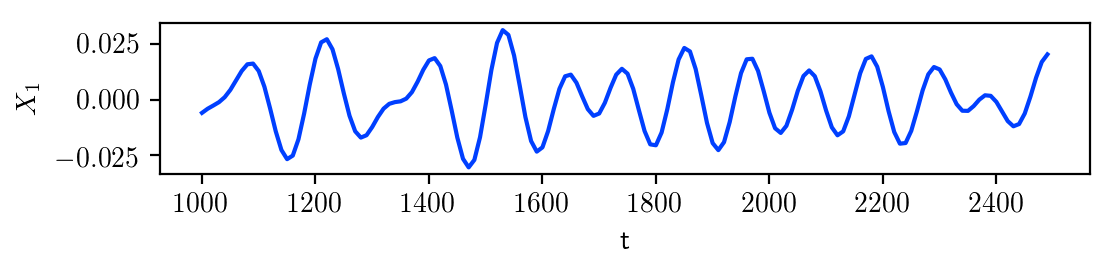

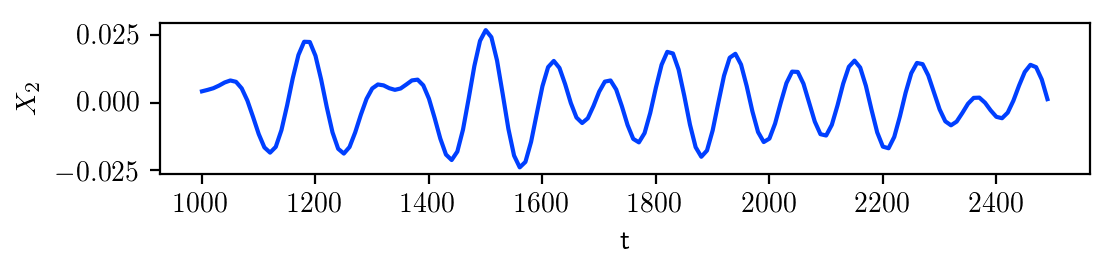

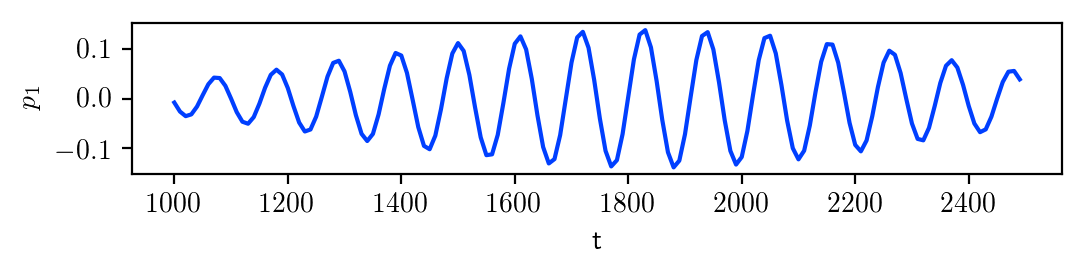

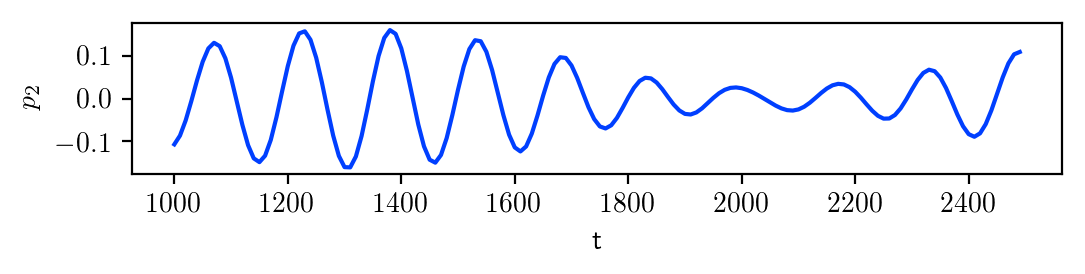

In [412]:
r_min_plot = r_min
r_max_plot = r_max
print len(result[:, 0])

plot_t_range = range(1000,2500,10)

rr_plot = np.linspace(r_min_plot, r_max_plot, 500)

result = np.array(t_all)

X_1_result = result[:, 0];
X_2_result = result[:,1];
p_1_result = result[:,2];
p_2_result = result[:,3]; 

X_1_vec = np.array([])
X_2_vec = np.array([])
p_1_vec = np.array([])
p_2_vec = np.array([])

r_to_plot = 2
print plot_t_range[-1]

for t_i in plot_t_range:
    X_1_vec = np.append(X_1_vec, X_1_result[t_i](r_to_plot))
    X_2_vec = np.append(X_2_vec, X_2_result[t_i](r_to_plot))
    p_1_vec = np.append(p_1_vec, p_1_result[t_i](r_to_plot))
    p_2_vec = np.append(p_2_vec, p_2_result[t_i](r_to_plot))


plt.figure(figsize=(6,1))
plt.plot(plot_t_range, X_1_vec);
plt.ylabel("$X_1$");plt.xlabel("t")
plt.show()
plt.figure(figsize=(6,1))
plt.plot(plot_t_range, X_2_vec);
plt.ylabel("$X_2$");plt.xlabel("t")
plt.show()
plt.figure(figsize=(6,1))
plt.plot(plot_t_range, p_1_vec);
plt.ylabel("$p_1$");plt.xlabel("t")
#plt.yscale("symlog")
plt.show()
plt.figure(figsize=(6,1))
plt.plot(plot_t_range, p_2_vec);
plt.ylabel("$p_2$");plt.xlabel("t")
#plt.yscale("symlog")
plt.show()

#time_range = range(10,1000,100)

#print("length of time steps: ", len(t_all))
#plot_t_slice_fields(t_all, time_range, rr_plot, log=False)

In [414]:
plot_alpha = 0.7

def plot_t_slice_fields(t_all, t_slices, r, log=False):
    result = np.array(t_all)[t_slices]
    X_1_result = result[:,0]; X_2_result = result[:,1]; p_1_result = result[:,2]; p_2_result = result[:,3]; 
    grey_scale_color = np.linspace(0.0, 0.8, len(t_slices))

    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,5))
    plt.subplots_adjust(wspace = 0.2, hspace=0.5)
    for row in ax:
        for col in row:
           col.set_xlabel('$r$')
           col.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    for i, t_slice in enumerate(t_slices):
        if log:
            ax[0,0].plot(r, logit(X_1_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[0,0].plot(r, X_1_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[0,0].set_ylabel('$X_1$'); #ax[0,0].legend();
        
    for i, t_slice in enumerate(t_slices):
        if log:
            ax[1,1].plot(r, logit(X_2_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[1,1].plot(r, X_2_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[1,1].set_ylabel('$X_2$'); #ax[1,1].legend();

    for i, t_slice in enumerate(t_slices):
        if log:
            ax[1,0].plot(r, logit(p_1_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[1,0].plot(r, p_1_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[1,0].set_ylabel('$p_1$'); #ax[1,0].legend();
    
    for i, t_slice in enumerate(t_slices):
        if log:
            ax[2,0].plot(r, logit(p_2_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[2,0].plot(r, p_2_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[2,0].set_ylabel('$p_2$'); #ax[0,0].legend();
    

    print("Matter field contents")
    plt.show()

('length of time steps: ', 10001)
Matter field contents


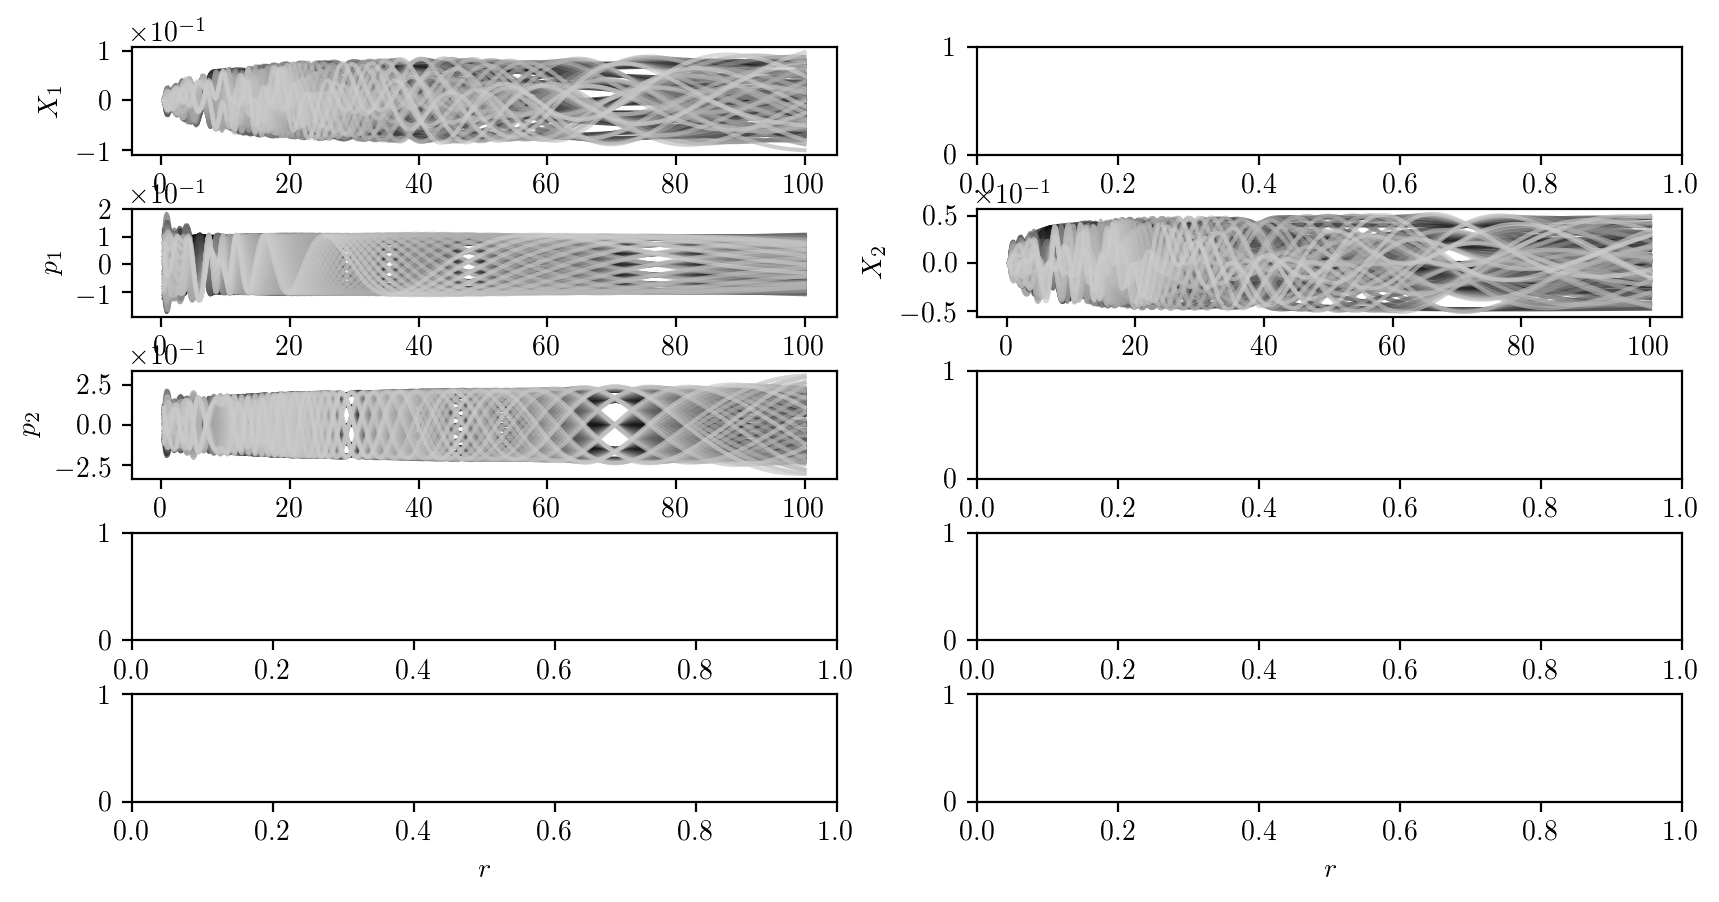

In [416]:
r_min_plot = r_min
r_max_plot = r_max

rr_plot = np.linspace(r_min_plot, r_max_plot, 500)
time_range = range(0,10000,100)
result = t_all

print("length of time steps: ", len(t_all))
plot_t_slice_fields(result, time_range, rr_plot, log=False)